In [1]:
%matplotlib notebook
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from lxml import html
import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Wikipedia article with raw data:
URL = 'https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_Wuhan_coronavirus_outbreak'

In [3]:
# Method to read the raw data from the Wikipedia article:
def read_wikipedia(url):
    page = requests.get(url)
    tree = html.fromstring(page.content)
    table = tree.xpath('/html/body/div[3]/div[3]/div[4]/div/table[2]/tbody')[0]
    data = []
    for row in table.xpath('.//tr'):
        date, confirmed = None, None
        try:
            confirmed = row.xpath('.//td[3]/text()')[0].strip()
            confirmed = confirmed.replace(',', '')
            if confirmed:
                confirmed = int(confirmed)
            else:
                confirmed = None
        except IndexError:
            confirmed = None
        try:
            date = row.xpath('.//td[1]/text()')[0].strip()
            if date:
                try:
                    date = datetime.strptime(date, '%Y-%m-%d')
                except ValueError:
                    date = None
            else:
                date = None
        except IndexError:
            date = None
        data.append((date, confirmed))
    data_frame = pd.DataFrame(data, columns=['date', 'confirmed'])
    data_frame.dropna(inplace=True)
    return data_frame

In [4]:
# Get the data:
data = read_wikipedia(URL)

In [5]:
# Print raw data table:
data

,date,confirmed
5,2020-01-10,40.0
6,2020-01-11,40.0
7,2020-01-12,40.0
8,2020-01-13,40.0
10,2020-01-16,31.0
11,2020-01-17,45.0
13,2020-01-19,170.0
14,2020-01-20,260.0
17,2020-01-23,771.0
18,2020-01-24,1208.0


In [6]:
# Get cases and days:
date_zero = data['date'].iloc[0]
days = (data['date'] - date_zero).dt.days.values
cases = data['confirmed'].values

In [7]:
# Create exponential model:
start_exp = 5
y, x = cases[start_exp:], days[start_exp:]
logy = np.log(y)
logx = np.log(x)
X = logx.reshape(-1, 1)
model_exp = LinearRegression().fit(X, logy)
print(model_exp.coef_, model_exp.intercept_)
# Estimate "y"-values:
log_y_hat = model_exp.predict(X)
y_hat = np.exp(log_y_hat)
rsq_exp = r2_score(y, y_hat)
print(rsq_exp)

[4.75549964] -5.318880782397018
0.8652397253053815


In [8]:
# Create polynomial model:
start_poly = 5
y, x = cases[start_poly:], days[start_poly:]
# X-matrix for y = a_0 + a_1 x + a_2 x²:
X = np.column_stack((x, x**2))
model_poly = LinearRegression().fit(X, y)
print(model_poly.coef_, model_poly.intercept_)
# Estimate y_hat
y_hat = model_poly.predict(X)
rsq_poly = r2_score(y, y_hat)
print(rsq_poly)

[-1761.2148174     92.33611881] 7970.8041000867615
0.9950632908732374


<IPython.core.display.Javascript object>


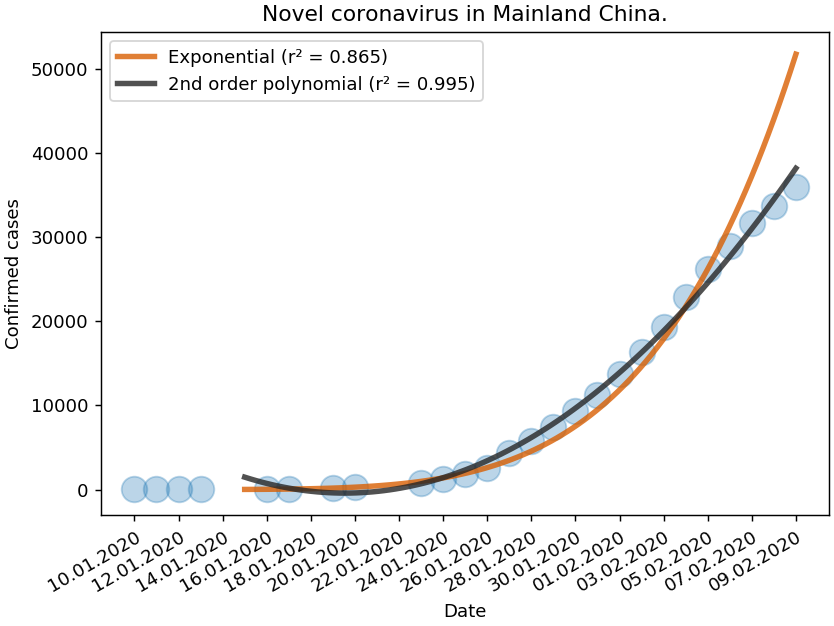

In [9]:
# Make a plot of cases and fitted models:
fig1, ax1 = plt.subplots(constrained_layout=True)
ax1.scatter(days, cases, s=200, alpha=0.3)
ax1.set_title('Novel coronavirus in Mainland China.')
ax1.set(xlabel='Date', ylabel='Confirmed cases')
# Add date ticks:
ticks = [i for i in range(0, days.max() + 1, 1)][::2]
times = [date_zero + timedelta(days=i) for i in ticks]
times_str = [i.strftime('%d.%m.%Y') for i in times]
ax1.set_xticks(ticks)
ax1.set_xticklabels(times_str, rotation=30,
                    rotation_mode='anchor', ha='right')
# Show the models:


x = np.linspace(start_exp, days.max(), 100)
X_exp = (np.log(x)).reshape(-1, 1)
y_exp = np.exp(model_exp.predict(X_exp))
ax1.plot(x, y_exp, color='#d95f02', lw=3, alpha=0.8,
         label='Exponential (r² = {:.3f})'.format(rsq_exp))

x = np.linspace(start_poly, days.max(), 100)
X_poly = np.column_stack((x, x**2))
y_poly = model_poly.predict(X_poly)
ax1.plot(x, y_poly, color='#262626', lw=3, alpha=0.8,
         label='2nd order polynomial (r² = {:.3f})'.format(rsq_poly))

ax1.legend()